# SINDy Model Identification on Lorenz System Data

An interactive version of this notebook is available on binder:   [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/urban-fasel/I-X_workshop_2025/HEAD?labpath=1_SINDy_ODE.ipynb)

This tutorial demonstrates how to use **SINDy (Sparse Identification of Nonlinear Dynamics)** to discover the governing equations of the Lorenz system directly from noisy data.

The Lorenz system is defined by the following set of three coupled, nonlinear ordinary differential equations:

$$
\begin{align}
\dot{x} &= \sigma(y-x) \\
\dot{y} &= x(\rho-z)-y \\
\dot{z} &= xy - \beta z
\end{align}
$$

Here, $\sigma$, $\rho$, and $\beta$ are system parameters, and $\dot{x}$, $\dot{y}$, and $\dot{z}$ represent the derivatives of the state variables with respect to time.

The tutorial is split into five steps:

- Generate noisy data: integrate the Lorenz system ODE and add Gaussian white noise
- Compute derivatives: using finite difference
- Build the library $\Theta$, here using polynomials up to order 3
- Compute sparse regression
- Evaluate the performance of the identified SINDy model for forecasting
- Run the same with PySINDy


Ensure you have the 'utils.py' file in the same directory, and make sure you have the required libraries installed, e.g. !pip install numpy scipy matplotlib pysindy ...


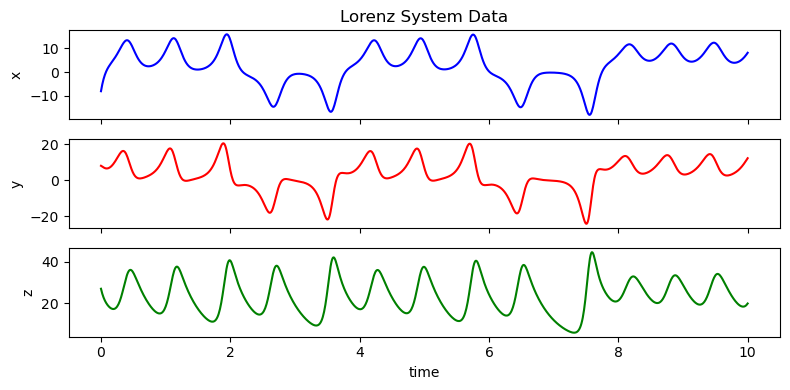

In [1]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import from the utils file
from utils import plot_sindy 

# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'RK45' #'LSODA'
integrator_keywords['atol'] = 1e-12


# ------------------------------------------------
# 1. Generate Noisy Lorenz System Data
# ------------------------------------------------

# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
params = [sigma, rho, beta]

# Initial conditions x0, time step dt, and time span tspan
x0 = [-8, 8, 27]
dt = 0.01
t_span = (0, 10)
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Lorenz system right-hand side function
def lorenz_system(t, x, params):
    dx = params[0] * (x[1] - x[0])
    dy = x[0] * (params[1] - x[2]) - x[1]
    dz = x[0] * x[1] - params[2] * x[2]
    return [dx, dy, dz]

# Solve the initial value problem: Runga-Kutta method
solution = solve_ivp(
    fun=lorenz_system,
    t_span=t_span,
    y0=x0,
    args=(params,),
    t_eval=t_eval,
    **integrator_keywords
)
x_true = solution.y.T

# Add Gaussian white noise
np.random.seed(1)
sig = 0.0
x_noisy = x_true + sig * np.std(x_true) * np.random.randn(*x_true.shape)

# Plot the noisy time series data
fig = plt.figure(figsize=(8, 4))
labels = ['x', 'y', 'z']
colors = ['b', 'r', 'g']
for i in range(3):
    ax = fig.add_subplot(3, 1, i + 1)
    ax.plot(t_eval, x_noisy[:, i], colors[i])
    ax.set_ylabel(labels[i])
    if i < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('time')
    if i == 0:
        ax.set_title('Lorenz System Data')
plt.tight_layout()
plt.show()

In [2]:
# ------------------------------------------------
# 2. Compute Derivatives (finite difference)
# ------------------------------------------------

# Compute derivatives using finite difference (4th order central difference)
dx_dt = (1/(12*dt)) * (-x_noisy[5:, :] + 8*x_noisy[4:-1, :] - 8*x_noisy[2:-3, :] + x_noisy[1:-4, :])
x = x_noisy[3:-2, :] # cut tails
t = t_eval[3:-2]


In [3]:
# ------------------------------------------------
# 3. Build library of nonlinear terms
# ------------------------------------------------

# Build the library using the pooldata function defined in utils.py

def poolData(x, polyorder):
    """Builds a polynomial library of candidate functions."""

    # If the input is a 1D array, convert it to a 2D array for consistent processing.
    if x.ndim == 1:
        x = x.reshape(1, -1)
    
    n_samples, n_vars = x.shape
    ind = 0
    # Add a column for the constant term (1)
    theta = np.ones((n_samples, 1))
    ind += 1

    # Poly order 1
    for i in range(n_vars):
        theta = np.hstack([theta, x[:, i:i+1]])
        ind += 1
    
    # Poly order 2
    if polyorder >= 2:
        for i in range(n_vars):
            for j in range(i, n_vars):
                theta = np.hstack([theta, (x[:, i] * x[:, j]).reshape(-1, 1)])
                ind += 1

    # Poly order 3
    if polyorder >= 3:
        for i in range(n_vars):
            for j in range(i, n_vars):
                for k in range(j, n_vars):
                    theta = np.hstack([theta, (x[:, i] * x[:, j] * x[:, k]).reshape(-1, 1)])
                    ind += 1
    
    return theta


# polynomials up to order 3
polyorder = 3 
theta = poolData(x, polyorder)

print("the library matrix theta has", theta.shape[0], "rows (time steps), and", theta.shape[1], "columns (nonlinear library terms).")

print(theta)

the library matrix theta has 996 rows (time steps), and 20 columns (nonlinear library terms).
[[ 1.00000000e+00 -3.94150621e+00  7.31298837e+00 ...  1.26367034e+03
   4.08303346e+03  1.31926513e+04]
 [ 1.00000000e+00 -2.88204816e+00  7.07817171e+00 ...  1.14057382e+03
   3.66845773e+03  1.17989575e+04]
 [ 1.00000000e+00 -1.94437992e+00  6.87385318e+00 ...  1.03955593e+03
   3.32732304e+03  1.06498152e+04]
 ...
 [ 1.00000000e+00  6.70656060e+00  1.00107204e+01 ...  1.86738646e+03
   3.47594120e+03  6.47009469e+03]
 [ 1.00000000e+00  7.04674726e+00  1.05450735e+01 ...  2.09509947e+03
   3.74335021e+03  6.68830811e+03]
 [ 1.00000000e+00  7.40591349e+00  1.10890080e+01 ...  2.35071166e+03
   4.05247771e+03  6.98621439e+03]]


In [4]:
# ------------------------------------------------
# 4. Compute Sparse Regression
# ------------------------------------------------

# Function for sequential thresholded least squares (STLS)
def sparsifyDynamics(theta, dx_dt, threshold, n_vars):
    xi = np.linalg.lstsq(theta, dx_dt)[0] # Initial guess: Least-squares

    for _ in range(10): # Iterative thresholding
        small_coeffs = (np.abs(xi) < threshold) # Find small coefficients
        xi[small_coeffs] = 0 # and threshold
        
        for i in range(n_vars):  # n_vars is state dimension
            big_coeffs_idx = ~small_coeffs[:, i]
            # regress dynamics onto remaining terms to find sparse Xi
            xi[big_coeffs_idx, i] = np.linalg.lstsq(theta[:, big_coeffs_idx], dx_dt[:, i])[0]
    return xi
    
# Perform sparse regression
threshold = 0.1 # this is the sparsification parameter: coefficients below this value are set to zero
n_vars = x_true.shape[1] # number of states -> 3
xi = sparsifyDynamics(theta, dx_dt, threshold, n_vars)

# Print the identified model
print("Identified SINDy Model Coefficients:")
print(np.round(xi, 4))

Identified SINDy Model Coefficients:
[[ 0.      0.      0.    ]
 [-9.9999 27.9978  0.    ]
 [ 9.9999 -0.9995  0.    ]
 [ 0.      0.     -2.6666]
 [ 0.      0.      0.    ]
 [ 0.      0.      1.    ]
 [ 0.     -0.9999  0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]]


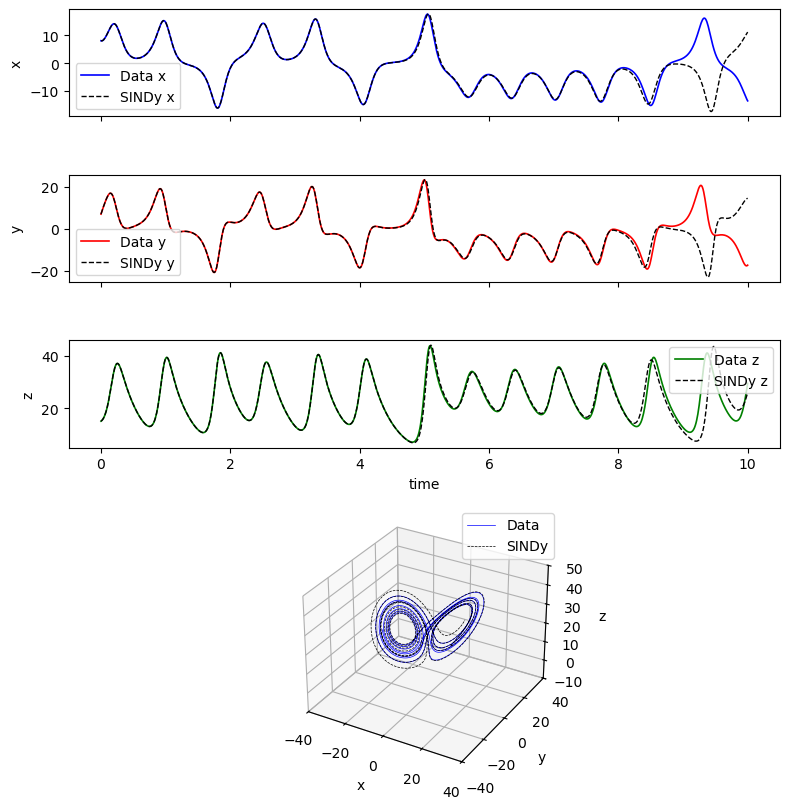

In [5]:
# ------------------------------------------------
# 5 Evaluate Performance of SINDy Model for Forecasting
# ------------------------------------------------

# Define the SINDy ODE function for integration
def sindy_ode(t, x, params):
    # This function needs the 'poolData' and 'xi' from the main script
    theta_ode = poolData(x, params['polyorder'])
    dx = (theta_ode @ params['xi']).flatten()
    return dx

# Parameters for the ODE solver
sindy_params = {'xi': xi, 'polyorder': polyorder}

# test trajectory from new initial condition
x0_test = [8, 7, 15]
t_test = t_eval

# solve the initial value problem
solution = solve_ivp(
    fun=lorenz_system,
    t_span=t_span,
    y0=x0_test,
    args=(params,),
    t_eval=t_test,
    **integrator_keywords
)
x_test_true = solution.y.T

# Simulate the learned model
sindy_solution = solve_ivp(
    fun=sindy_ode,
    t_span=t_span,
    y0=x0_test,
    args=(sindy_params,),
    t_eval=t_eval,
    **integrator_keywords
)
x_sindy_sim = sindy_solution.y.T

# Plot the comparison between the test data and the SINDy prediction
plot_sindy(t_test, x_test_true, t_test, x_sindy_sim)

In [6]:
# ------------------------------------------------
# 6. PySINDy
# ------------------------------------------------

# install PySINDy
# !pip install pysindy

import pysindy as ps

# Instantiate and fit the SINDy model
model = ps.SINDy() # default solver (STLSQ with threshold = 0.1)
model.fit(x, t=dt, feature_names=["x", "y", "z"]) # default x_dot (finite difference - centered, 2nd order)
model.print()

(x)' = -9.979 x + 9.979 y
(y)' = 27.807 x + -0.964 y + -0.995 x z
(z)' = -2.659 z + 0.997 x y


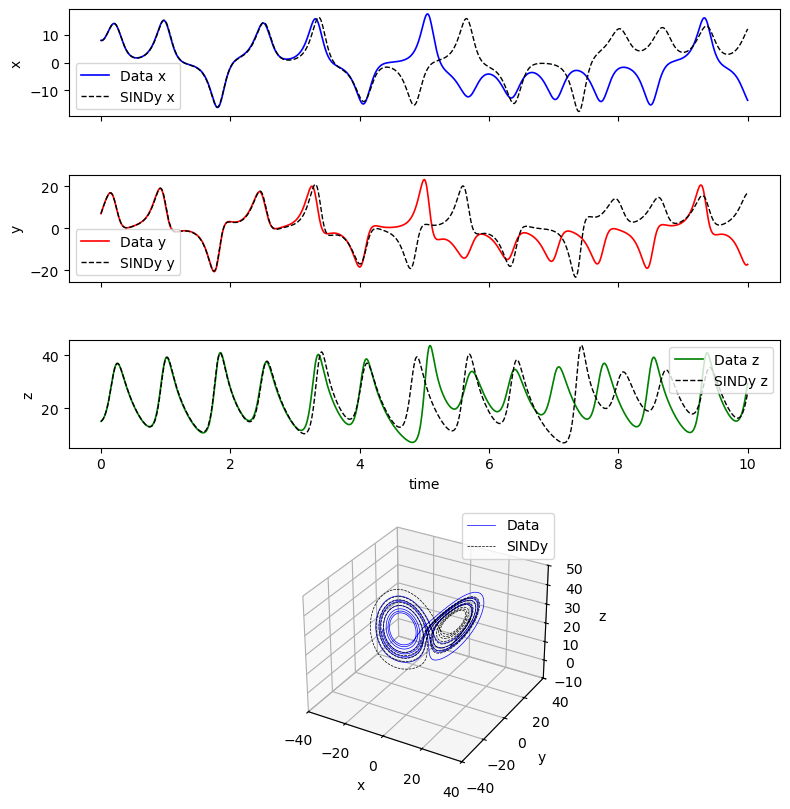

In [7]:
# Evolve the new initial condition in time with the SINDy model
x_test_pysindy = model.simulate(x0_test, t_test)

# Plot the comparison between the original data and the PySINDy prediction
plot_sindy(t_test, x_test_true, t_test, x_test_pysindy)

In [8]:
# reproduce results above -> change order of finite difference

# select optimizer -> default is sequentially thresholded least squares (default)
optimizer = ps.STLSQ(threshold=0.2)
# choose differentiation method -> default is centered difference 2nd order
# here we use centered difference 4th order (or we can directly use the computed time derivatives in model.fit -> model.fit(x, t=dt, x_dot=dx_dt))
differentiation_method = ps.FiniteDifference(order=4)
# choose library -> default is polynomial 3rd order
feature_library = ps.PolynomialLibrary(degree=3)

# Instantiate and fit the SINDy model
model = ps.SINDy(optimizer = optimizer, 
                 differentiation_method = differentiation_method,
                 feature_library=feature_library)
model.fit(x, t=dt, feature_names=["x", "y", "z"])
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


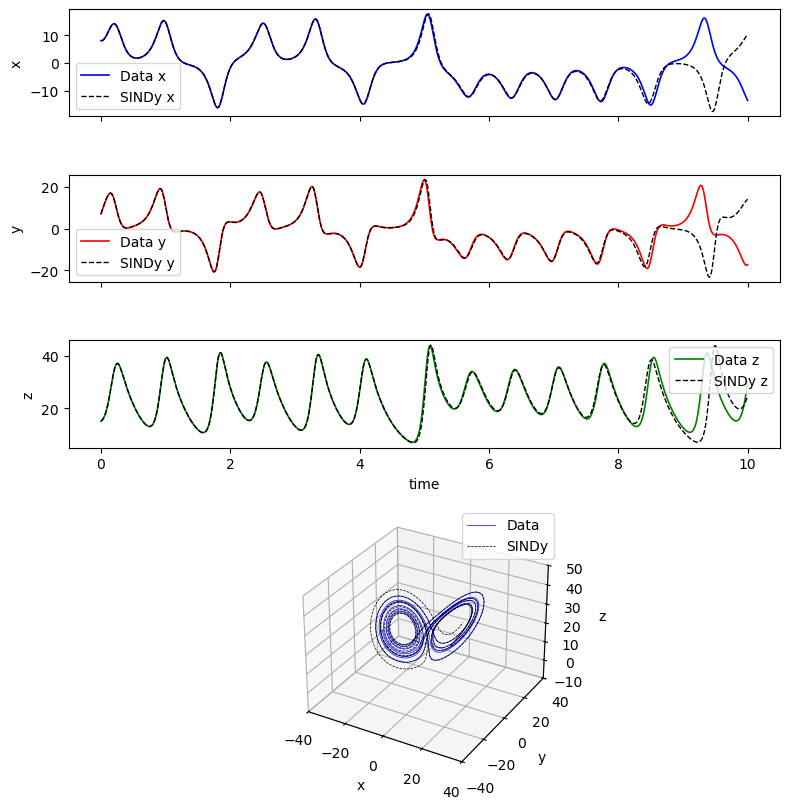

In [9]:
# Evolve the new initial condition in time with the SINDy model
x_test_pysindy = model.simulate(x0_test, t_test)

# Plot the comparison between the original data and the PySINDy prediction
plot_sindy(t_test, x_test_true, t_test, x_test_pysindy)